In this approach we use Bag of decision trees.
**Features:**

Surrouding cells for a given cell.

**Data Augmentation**
* Background color is detected using custom logic.
* Custom logic is written to find the colors which need to be excempted from augmentation.
 * All the colors which are present in all the input of training exmaples are marked for excemption.
 * Color which is not present in input but present in output are excepted.
* For rest of colors all permutations are used to augment.

**Model** 

 Bag of decision trees are used since, single decision tree have some randomness factor which may give incorrect result.
 
 **Result**
 
 Training: Solved 41/400


In [12]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from pathlib import Path
from collections import defaultdict
from itertools import product
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations,permutations
from sklearn.tree import *
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
import random
from math import floor


In [13]:
data_path = Path("/kaggle/input/abstraction-and-reasoning-challenge")
train_path = data_path/'training'
test_path = data_path/'test'

In [14]:
def plot_result(inp,eoup,oup):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 3, figsize=(15,15))
    
    axs[0].imshow(inp, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Input')

    axs[1].imshow(eoup, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Output')
    
    axs[2].imshow(oup, cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Model prediction')
    
    plt.grid()
    plt.tight_layout()
    plt.show()
    
def plot_training(inp,eoup):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 2, figsize=(15,15))
    
    axs[0].imshow(inp, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Input')

    axs[1].imshow(eoup, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Output')
    
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_mat(inp, title = "Input"):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    
    axs.imshow(inp, cmap=cmap, norm=norm)
    axs.axis('on')
    axs.set_title(title)
  
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_mats(mats):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, len(mats), figsize=(15,15))
    
    for i in range(len(mats)):
        axs[i].imshow(mats[i], cmap=cmap, norm=norm)
        axs[i].axis('off')
        axs[i].set_title('Fig: '+str(i))
    
    plt.rc('grid', linestyle="-", color='white')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
def getiorc(pair):
    inp = pair["input"]
    return pair["input"],pair["output"],len(inp),len(inp[0])
    
def getAround(i,j,inp,size=1):
    #v = [-1,-1,-1,-1,-1,-1,-1,-1,-1]
    r,c = len(inp),len(inp[0])
    v = []
    sc = [0]
    for q in range(size):
        sc.append(q+1)
        sc.append(-(q+1))
    for idx,(x,y) in enumerate(product(sc,sc)):
        ii = (i+x)
        jj = (j+y)
        v.append(-1)
        if((0<= ii < r) and (0<= jj < c)):
            v[idx] = (inp[ii][jj])
    return v

def getDiagonal(i,j,r,c):
    return
        
    
def getX(inp,i,j,size):
    z = []
    n_inp = np.array(inp)
    z.append(i)
    z.append(j)
    r,c = len(inp),len(inp[0])
    for m in range(5):
        z.append(i%(m+1))
        z.append(j%(m+1))
    z.append(i+j)
    z.append(i*j)
#     z.append(i%j)
#     z.append(j%i)
    z.append((i+1)/(j+1))
    z.append((j+1)/(i+1))
    z.append(r)
    z.append(c)
    z.append(len(np.unique(n_inp[i,:])))
    z.append(len(np.unique(n_inp[:,j])))
    arnd = getAround(i,j,inp,size)
    z.append(len(np.unique(arnd)))
    z.extend(arnd)
    return z

    
def getXAll(inp,i,j):
    z = []
    z.append(inp[i][j])
    """
    z.append(i)
    z.append(j)
    for m in range(5):
        z.append(i%(m+1))
        z.append(j%(m+1))
    z.append(i+j)
    z.append(i*j)
    z.append((i+1)/(j+1))
    z.append((j+1)/(i+1))
    """
    r,c = len(inp),len(inp[0])
    for i in range(r):
        for j in range(c):
            z.append(inp[i][j])
    return z

def getXy(inp,oup,size):
    x = []
    y = []
    r,c = len(inp),len(inp[0])
    for i in range(r):
        for j in range(c):
            x.append(getX(inp,i,j,size))
            y.append(oup[i][j])
    return x,y
    
def getXyAll(inp,oup):
    x = []
    y = []
    r,c = len(inp),len(inp[0])
    for i in range(r):
        for j in range(c):
            x.append(getXAll(inp,i,j))
            y.append(oup[i][j])
    return x,y
    
def getBkgColor(task_json):
    color_dict = defaultdict(int)
    
    for pair in task_json['train']:
        inp,oup,r,c = getiorc(pair)
        for i in range(r):
            for j in range(c):
                color_dict[inp[i][j]]+=1
    color = -1
    max_count = 0
    for col,cnt in color_dict.items():
        if(cnt > max_count):
            color = col
            max_count = cnt
    return color

In [16]:
def get_num_colors(inp,oup,bl_cols):
    r,c = len(inp),len(inp[0])
    return 

def replace(inp,uni,perm):
    # uni = '234' perm = ['5','7','9']
    #print(uni,perm)
    r_map = { int(c):int(s) for c,s in zip(uni,perm)}
    r,c = len(inp),len(inp[0])
    rp = np.array(inp).tolist()
    #print(rp)
    for i in range(r):
        for j in range(c):
            if(rp[i][j] in r_map):
                rp[i][j] = r_map[rp[i][j]]
    return rp
            
    
def augment(inp,oup,bl_cols):
    cols = "0123456789"
    npr_map = [1,9,72,3024,15120,60480,181440,362880,362880]
    uni = "".join([str(x) for x in np.unique(inp).tolist()])
    for c in bl_cols:
        cols=cols.replace(str(c),"")
        uni=uni.replace(str(c),"")

    exp_size = len(inp)*len(inp[0])*npr_map[len(uni)]
#    print("cols",cols,"uni",uni,"exp_size",exp_size)
    mod = floor(exp_size/120000)
    mod = 1 if mod==0 else mod
    
    #print(exp_size,mod,len(uni))
    result = []
    count = 0
    for comb in combinations(cols,len(uni)):
        for perm in permutations(comb):
            count+=1
            if(count % mod == 0):
                result.append((replace(inp,uni,perm),replace(oup,uni,perm)))
    return result
            
def get_flips(inp,oup):
    result = []
    n_inp = np.array(inp)
    n_oup = np.array(oup)
    result.append((np.fliplr(inp).tolist(),np.fliplr(oup).tolist()))
    result.append((np.rot90(np.fliplr(inp),1).tolist(),np.rot90(np.fliplr(oup),1).tolist()))
    result.append((np.rot90(np.fliplr(inp),2).tolist(),np.rot90(np.fliplr(oup),2).tolist()))
    result.append((np.rot90(np.fliplr(inp),3).tolist(),np.rot90(np.fliplr(oup),3).tolist()))
    result.append((np.flipud(inp).tolist(),np.flipud(oup).tolist()))
    result.append((np.rot90(np.flipud(inp),1).tolist(),np.rot90(np.flipud(oup),1).tolist()))
    result.append((np.rot90(np.flipud(inp),2).tolist(),np.rot90(np.flipud(oup),2).tolist()))
    result.append((np.rot90(np.flipud(inp),3).tolist(),np.rot90(np.flipud(oup),3).tolist()))
    result.append((np.fliplr(np.flipud(inp)).tolist(),np.fliplr(np.flipud(oup)).tolist()))
    result.append((np.flipud(np.fliplr(inp)).tolist(),np.flipud(np.fliplr(oup)).tolist()))
    return result
    
def get_4_flips(inp,oup):
    result = []
    n_inp = np.array(inp)
    n_oup = np.array(oup)
    result.append((np.fliplr(inp).tolist(),np.fliplr(oup).tolist()))
    result.append((np.flipud(inp).tolist(),np.flipud(oup).tolist()))
    result.append((np.rot90(inp).tolist(),np.rot90(oup).tolist()))
    result.append((np.rot90(inp,3).tolist(),np.rot90(oup,3).tolist()))
    return result

def gettaskxy(task_json,aug,around_size,bl_cols,flip=True):    
    X = []
    Y = []
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        tx,ty = getXy(inp,oup,around_size)
#        tx,ty = getXyAll(inp,oup)
        X.extend(tx)
        Y.extend(ty)
        if(flip):
            for ainp,aoup in get_flips(inp,oup):
                tx,ty = getXy(ainp,aoup,around_size)
#                tx,ty = getXyAll(ainp,aoup)
                X.extend(tx)
                Y.extend(ty)
                if(aug):
                    augs = augment(ainp,aoup,bl_cols)
                    for ainp,aoup in augs:
                        tx,ty = getXy(ainp,aoup,around_size)
#                        tx,ty = getXyAll(ainp,aoup)
                        X.extend(tx)
                        Y.extend(ty)
        if(aug):
            augs = augment(inp,oup,bl_cols)
            for ainp,aoup in augs:
                tx,ty = getXy(ainp,aoup,around_size)
#                tx,ty = getXyAll(ainp,aoup)
                X.extend(tx)
                Y.extend(ty)
    return X,Y

def test_predict(task_json,model,size):
    inp = task_json['test'][0]['input']
    eoup = task_json['test'][0]['output']
    r,c = len(inp),len(inp[0])
    oup = predict(inp,model,size)
    return inp,eoup,oup

def predict(inp,model,size):
    r,c = len(inp),len(inp[0])
    oup = np.zeros([r,c],dtype=int)
    for i in range(r):
        for j in range(c):
            x = getX(inp,i,j,size)
#            x = getXAll(inp,i,j)
            o = int(model.predict([x]))
            o = 0 if o<0 else o
            oup[i][j]=o
    return oup

def submit_predict(task_json,model,size):
    pred_map = {}
    idx=0
    for pair in task_json['test']:
        inp = pair["input"]
        oup = predict(inp,model,size)
        pred_map[idx] = oup.tolist()
        idx+=1
        plot_result(inp,oup,oup)
    return pred_map

def dumb_predict(task_json):
    pred_map = {}
    idx=0
    for pair in task_json['test']:
        inp = pair["input"]
        pred_map[idx] = [[0,0],[0,0]]
        idx+=1
    return pred_map
    

In [17]:
# difference in matrix size
def get_size_loss(test, oup):
    return (len(test) - len(oup)) + (len(test[0]) - len(oup[0]))

# difference in pixel count other then back ground colour if -ve then less pixel or if +ve then extra pixel 
# if both image have same number of pixel with same colour then return 0
# return first colour of test that is not present in out or colour with different count
def get_count_loss(bg_col, test, oup):
    u_test, uc_test = np.unique(test, return_counts = True)
    u_oup, uc_oup = np.unique(oup, return_counts = True)
    for uni_col in u_test:
        if uni_col == bg_col:
            continue
        if uni_col not in u_oup:
            return uni_col, -1
        diff = uc_oup[u_oup.index(uni_col)] - uc_test[u_test.index(uni_col)]
        if diff != 0:
            return uni_col, diff
    return -1, -1

# difference in pixel count other then back ground colour if -ve then less pixel or if +ve then extra pixel 
# if both image have same number of pixel with same colour then return 0
# return first colour of test that is not present in out or colour with different count
def get_col_count_loss(bg_col, test, oup):
    u_test, uc_test = np.unique(test, return_counts = True)
    u_oup, uc_oup = np.unique(oup, return_counts = True)
    for uni_col in u_test:
        if uni_col == bg_col:
            continue
        if uni_col not in u_oup:
            return uni_col, -1
        diff = uc_oup[u_oup.index(uni_col)] - uc_test[u_test.index(uni_col)]
        if diff != 0:
            return uni_col, diff
    return -1, -1

# at this point we are assuming that input/test and output have same number of colour
# this function will return error in terms of distance of nearest same colour pixel 
#def get_shift_loss(bg_col, test, oup):
    

def get_total_loss(bg_col, test, oup):
    return get_count_loss(bg_col, test, oup)

def get_loss(model,task_json,size):
    total = 0
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        eoup = predict(inp,model,size)
        total+= np.sum((np.array(oup) != np.array(eoup)))
    return total

def get_test_loss(model,task_json,size):
    total = 0
    for pair in task_json['test']:
        inp,oup=pair["input"],pair["output"]
        eoup = predict(inp,model,size)
        total+= np.sum((np.array(oup) != np.array(eoup)))
    return total

def get_a_size(task_json):
    return 4;

def get_bl_cols(task_json):
    result = []
    bkg_col = getBkgColor(task_json);
    result.append(bkg_col)
    # num_input,input_cnt,num_output,output_cnt
    met_map = {}
    for i in range(10):
        met_map[i] = [0,0,0,0]
        
    total_ex = 0
    # for each input and output pair create a map of unique colours and their count
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        u,uc = np.unique(inp, return_counts=True)
        inp_cnt_map = dict(zip(u,uc))
        u,uc = np.unique(oup, return_counts=True)
        oup_cnt_map = dict(zip(u,uc))
        # add unique colours and their count to common map
        for col,cnt in inp_cnt_map.items():
            met_map[col][0] = met_map[col][0] + 1
            met_map[col][1] = met_map[col][1] + cnt
        for col,cnt in oup_cnt_map.items():
            met_map[col][2] = met_map[col][2] + 1
            met_map[col][3] = met_map[col][3] + cnt
        total_ex+=1
    # now each row of met_map represent a colour and their total count of all examples of input and output
    for col,met in met_map.items():
        num_input,input_cnt,num_output,output_cnt = met
        # record a colour if it appears in both input and output of all examples
        if(num_input == total_ex or num_output == total_ex):
            result.append(col)
        # record a colour if it is not present in any input but present in atleast one output of all examples
        elif(num_input == 0 and num_output > 0):
            result.append(col)
    
    result = np.unique(result).tolist()
    if(len(result) == 10):
        result.append(bkg_col)
    return np.unique(result).tolist()


In [18]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def combine_preds(tid,pm1,pm3,pm5):
    result = []
    for i in range(len(pm1)):
        tk_s = tid+"_"+str(i)
        str_pred = flattener(pm1[i])+" "+flattener(pm3[i])+" "+flattener(pm5[i])
        #print(tk_s,str_pred)
        result.append([tk_s,str_pred])
    return result
        

In [19]:
"""
def inp_oup_dim_same(task_json):
    return all([ len(pair["input"]) == len(pair["output"]) and len(pair["input"][0]) == len(pair["output"][0])
                for pair in task_json['train']])
    

solved_task = 0
total_task = 0
task_ids = []
task_preds = []
for task_path in test_path.glob("*.json"):
    task_json = json.load(open(task_path))
    tk_id = str(task_path).split("/")[-1].split(".")[0]
    print(tk_id)
    print(len(task_json['train']))
    continue
    if(inp_oup_dim_same(task_json)):
        a_size = get_a_size(task_json)
        bl_cols = get_bl_cols(task_json)
        
        isflip = False
        X1,Y1 = gettaskxy(task_json,True,1,bl_cols,isflip)
        X3,Y3 = gettaskxy(task_json,True,3,bl_cols,isflip)
        X5,Y5 = gettaskxy(task_json,True,5,bl_cols,isflip)
        
        model_1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100).fit(X1, Y1)
        model_3 = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100).fit(X3, Y3)
        model_5 = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100).fit(X5, Y5)
        
        pred_map_1 = submit_predict(task_json,model_1,1)
        pred_map_3 = submit_predict(task_json,model_3,3)
        pred_map_5 = submit_predict(task_json,model_5,5)
        
        for tks,str_pred in combine_preds(tk_id,pred_map_1,pred_map_3,pred_map_5):
            task_ids.append(tks)
            task_preds.append(str_pred)
            #print(tks,str_pred)
        solved_task+=1
        #break
    else:
        pred_map_1 = dumb_predict(task_json)
        pred_map_3 = dumb_predict(task_json)
        pred_map_5 = dumb_predict(task_json)
        
        for tks,str_pred in combine_preds(tk_id,pred_map_1,pred_map_3,pred_map_5):
            task_ids.append(tks)
            task_preds.append(str_pred)
            #print(tks,str_pred)
        
    total_task+=1
"""

'\ndef inp_oup_dim_same(task_json):\n    return all([ len(pair["input"]) == len(pair["output"]) and len(pair["input"][0]) == len(pair["output"][0])\n                for pair in task_json[\'train\']])\n    \n\nsolved_task = 0\ntotal_task = 0\ntask_ids = []\ntask_preds = []\nfor task_path in test_path.glob("*.json"):\n    task_json = json.load(open(task_path))\n    tk_id = str(task_path).split("/")[-1].split(".")[0]\n    print(tk_id)\n    print(len(task_json[\'train\']))\n    continue\n    if(inp_oup_dim_same(task_json)):\n        a_size = get_a_size(task_json)\n        bl_cols = get_bl_cols(task_json)\n        \n        isflip = False\n        X1,Y1 = gettaskxy(task_json,True,1,bl_cols,isflip)\n        X3,Y3 = gettaskxy(task_json,True,3,bl_cols,isflip)\n        X5,Y5 = gettaskxy(task_json,True,5,bl_cols,isflip)\n        \n        model_1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100).fit(X1, Y1)\n        model_3 = BaggingClassifier(base_estimator=DecisionT

In [20]:
 
def get_shapes(inp, out, bl_cols):    
    in_shapes = {}
    out_shapes = {}
    r,c = len(inp),len(inp[0])
    for i in range(r):
        for j in range(c):
            if inp[i][j] not in bl_cols:
                if inp[i][j] in in_shapes:
                    in_shapes[inp[i][j]].append([i,j])
                else:
                    in_shapes.update({inp[i][j]:[[i,j]]})
    r,c = len(out),len(out[0])
    for i in range(r):
        for j in range(c):
            if out[i][j] not in bl_cols:
                if out[i][j] in out_shapes:
                    out_shapes[out[i][j]].append([i,j])
                else:
                    out_shapes.update({out[i][j]:[[i,j]]})
    return in_shapes,out_shapes
                            


In [21]:
def get_shapes_comb(inp, out, bl_cols):
    in_pixels = [] # colour code, x, y
    r,c = len(inp),len(inp[0])
    for i in range(r):
        for j in range(c):
            if inp[i][j] != bl_cols[0]:
                in_pixels.append([inp[i][j],i,j])
                
    out_pixels = [] # colour code, x, y
    r,c = len(out),len(out[0])
    for i in range(r):
        for j in range(c):
            if out[i][j] != bl_cols[0]:
                out_pixels.append([out[i][j],i,j])
                
    in_shape_comb = []
    print(len(in_pixels))
    for comb_count in reversed(range(len(in_pixels) - 2, len(in_pixels))):
        for comb in combinations(in_pixels, comb_count):
            in_shape_comb.append(comb)
            
    out_shape_comb = []
#    for comb_count in reversed(range(1, len(out_pixels))):
#        for comb in combinations(out_pixels, comb_count):
#            out_shape_comb.append(comb)
    return in_shape_comb,out_shape_comb


In [70]:
a = np.array([ [0, 1, 2, 2, 0, 2, 2, 2],
               [0, 0, 1, 2, 2, 0, 3, 3],
               [0, 0, 2, 0, 0, 0, 0, 0],
               [0, 1, 2, 1, 2, 1, 2, 1]])
#a = a.tolist()
s = np.where(a == 2, a, 0).nonzero()
ans = np.unique(a)
shapes = {}
s = np.transpose(s).tolist()
print(s)
count = 0
for x,y in s:
    if not shapes: # if blank first entry
        shapes.update({count:[[x,y]]})
    else:
        near_found = False
        for key in shapes:
            shape_pix = shapes[key]
            if [x - 1, y] in shape_pix or [x, y - 1] in shape_pix or [x - 1, y - 1] in shape_pix:
                shapes[key].append([x,y])
                near_found = True
                break
        if not near_found:
            count += 1
            shapes.update({count:[[x,y]]})

print(shapes)

[[0, 2], [0, 3], [0, 5], [0, 6], [0, 7], [1, 3], [1, 4], [2, 2], [3, 2], [3, 4], [3, 6]]
{0: [[0, 2], [0, 3], [1, 3], [1, 4]], 1: [[0, 5], [0, 6], [0, 7]], 2: [[2, 2], [3, 2]], 3: [[3, 4]], 4: [[3, 6]]}


In [82]:
# Find same colour shape
def find_match_shapes(inp, bl_cols):
    n_inp = np.array(inp)
    uni = np.unique(n_inp).tolist()
    col_shapes = {}
    uni.remove(bl_cols[0])
    for col in uni:
        pos = np.where(n_inp == col, inp, bl_cols[0]).nonzero()
        pos = np.transpose(pos).tolist()
        shapes = {}
        count = 0
        for x,y in pos:
            if not shapes: # if blank first entry
                shapes.update({count:[[x,y]]})
            else:
                near_found = False
                for key in shapes:
                    shape_pix = shapes[key]
                    if [x - 1, y] in shape_pix or [x, y - 1] in shape_pix or [x - 1, y - 1] in shape_pix:
                        shapes[key].append([x,y])
                        near_found = True
                        break
                if not near_found:
                    count += 1
                    print("new",count, [x,y])
                    shapes.update({count:[[x,y]]})   
        col_shapes.update({col:shapes})
                    
    return col_shapes


In [ ]:
def train_predict(inp,model,size):
    oup = predict(inp,model,size)
    return inp,oup

1 /kaggle/input/abstraction-and-reasoning-challenge/training/0b148d64.json
2 /kaggle/input/abstraction-and-reasoning-challenge/training/54d9e175.json
4
[0, 1, 5, 6, 7, 8, 9]
Training Data
4
new 1 [1, 9]
new 1 [0, 7]


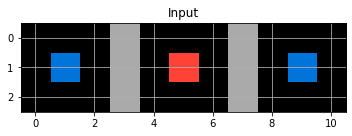

in_shapes {1: {0: [[1, 1]], 1: [[1, 9]]}, 2: {0: [[1, 5]]}, 5: {0: [[0, 3], [1, 3], [2, 3]], 1: [[0, 7], [1, 7], [2, 7]]}}


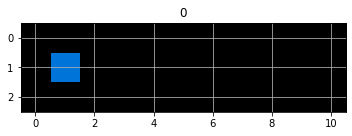

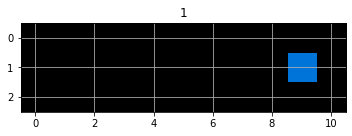

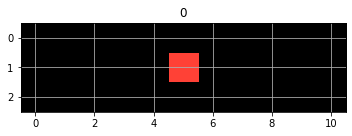

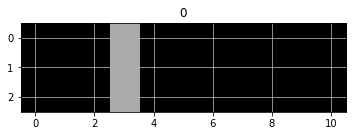

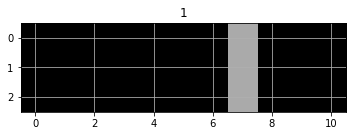

new 1 [0, 7]


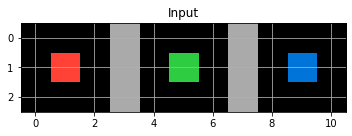

in_shapes {1: {0: [[1, 9]]}, 2: {0: [[1, 1]]}, 3: {0: [[1, 5]]}, 5: {0: [[0, 3], [1, 3], [2, 3]], 1: [[0, 7], [1, 7], [2, 7]]}}


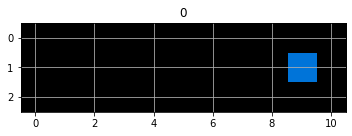

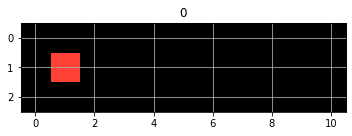

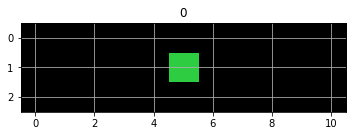

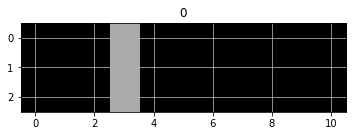

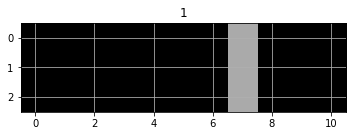

new 1 [0, 7]


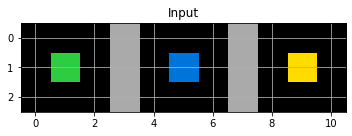

in_shapes {1: {0: [[1, 5]]}, 3: {0: [[1, 1]]}, 4: {0: [[1, 9]]}, 5: {0: [[0, 3], [1, 3], [2, 3]], 1: [[0, 7], [1, 7], [2, 7]]}}


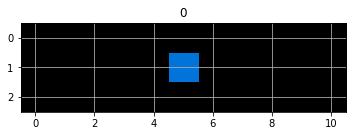

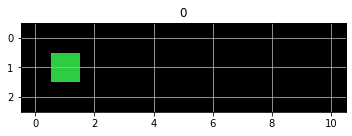

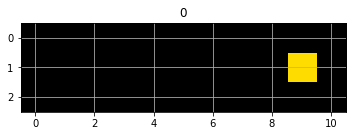

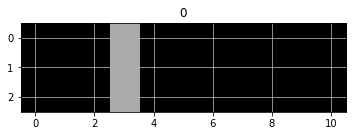

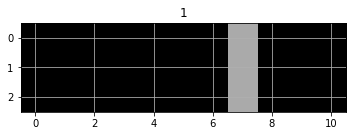

new 1 [5, 1]
new 1 [5, 9]
new 1 [0, 7]
new 2 [3, 0]


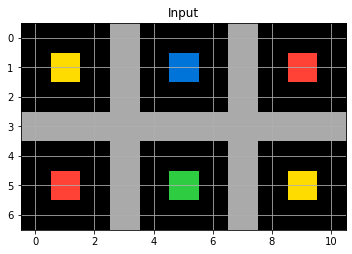

in_shapes {1: {0: [[1, 5]]}, 2: {0: [[1, 9]], 1: [[5, 1]]}, 3: {0: [[5, 5]]}, 4: {0: [[1, 1]], 1: [[5, 9]]}, 5: {0: [[0, 3], [1, 3], [2, 3], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [4, 3], [4, 7], [5, 3], [5, 7], [6, 3], [6, 7]], 1: [[0, 7], [1, 7], [2, 7]], 2: [[3, 0], [3, 1], [3, 2]]}}


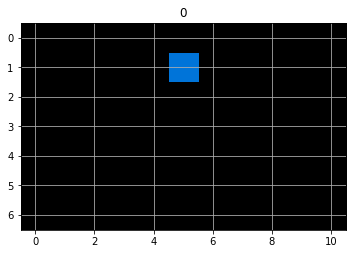

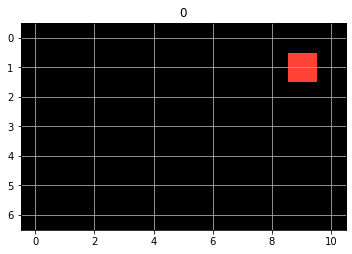

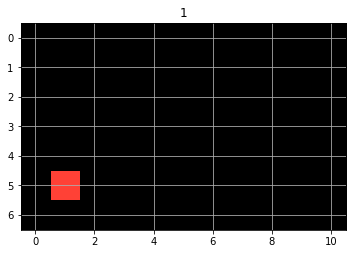

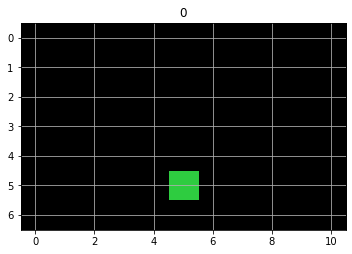

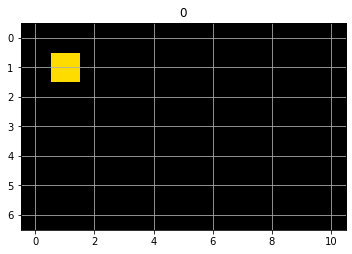

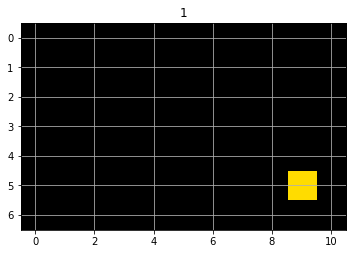

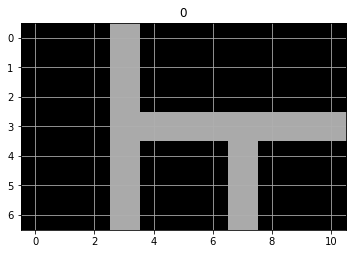

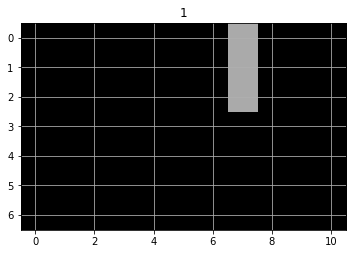

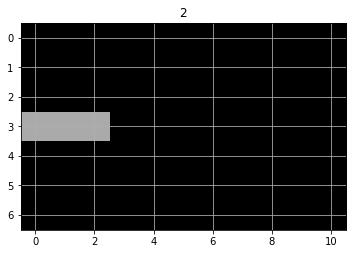

0 1


In [84]:
def inp_oup_dim_same(task_json):
    return all([ len(pair["input"]) == len(pair["output"]) and len(pair["input"][0]) == len(pair["output"][0])
                for pair in task_json['train']])

solved_task = 0
total_task = 0
index = 1
for task_path in train_path.glob("*.json"):
    task_json = json.load(open(task_path))
    print(index,task_path)
    index+=1
    if(inp_oup_dim_same(task_json)):
        a_size = get_a_size(task_json)
        print(a_size)
        bl_cols = get_bl_cols(task_json)
        print(bl_cols)
        """
        # Find the max row and column in the training set
        max_row = 0
        max_col = 0
        for pair in task_json['train']:
            max_row = max(len(pair["input"]), max_row)
            max_row = max(len(pair["output"]), max_row)
            max_col = max(len(pair["input"][0]), max_col)
            max_col = max(len(pair["output"][0]), max_col)
        for pair in task_json['test']:
            max_row = max(len(pair["input"]), max_row)
            max_row = max(len(pair["output"]), max_row)
            max_col = max(len(pair["input"][0]), max_col)
            max_col = max(len(pair["output"][0]), max_col)
            
        max_row = max(max_row, max_col)
        max_col = max_row
                
        # Add padding to the left and bottom to equalize size of training set
        for pair in task_json['train']:
            while len(pair["input"]) < max_row:
                pair["input"].append([0] * len(pair["input"][0]))
            while len(pair["input"][0]) < max_col:
                pair["input"] = [x + [0] for x in pair["input"]]
            while len(pair["output"]) < max_row:
                pair["output"].append([0] * len(pair["output"][0]))
            while len(pair["output"][0]) < max_col:
                pair["output"] = [x + [0] for x in pair["output"]]
            
        # Add padding to the left and bottom to equalize size of training set
        for pair in task_json['test']:
            while len(pair["input"]) < max_row:
                pair["input"].append([0] * len(pair["input"][0]))
            while len(pair["input"][0]) < max_col:
                pair["input"] = [x + [0] for x in pair["input"]]
            while len(pair["output"]) < max_row:
                pair["output"].append([0] * len(pair["output"][0]))
            while len(pair["output"][0]) < max_col:
                pair["output"] = [x + [0] for x in pair["output"]]
        """
        print("Training Data")
        print(len(task_json['train']))
        for pair in task_json['train']:
            inp,oup = pair["input"],pair["output"]
#            print(np.array(pair["input"]).shape,np.array(pair["output"]).shape)
#            plot_training(np.array(pair["input"]),np.array(pair["output"]))
            in_shapes = find_match_shapes(inp,bl_cols)
            plot_mat(np.array(pair["input"]))
            print("in_shapes",in_shapes)
#            print("out_shapes",out_shapes)
            count = 0
            for col in in_shapes:
                col_shapes = in_shapes[col]
                for count in col_shapes:
                    np_inp = np.full((len(inp),len(inp[0])), bl_cols[0])
                    count_shapes = col_shapes[count]
                    for pos in count_shapes:
                        np_inp[pos[0],pos[1]] = col
                    plot_mat(np_inp, str(count))
                    count += 1
                            
        isflip = False
#        X1,Y1 = gettaskxy(task_json,flip=True)
#        X1,Y1 = gettaskxy(task_json,True,5,bl_cols,isflip)
#        X3,Y3 = gettaskxy(task_json,True,5,bl_cols,isflip)
#        X5,Y5 = gettaskxy(task_json,True,5,bl_cols,isflip)
#        print("X1",np.array(X1), np.array(X1).shape)
#        print("\n")
#        print("Y1",np.array(Y1), np.array(Y1).shape)
        
#        model_1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100).fit(X1, Y1)
#        model_3 = BaggingClassifier(base_estimator=AdaBoostClassifier(),n_estimators=100).fit(X3, Y3)
#        model_5 = BaggingClassifier(base_estimator=ExtraTreesClassifier(),n_estimators=100).fit(X5, Y5)
#        model_5 = BaggingClassifier(base_estimator=LinearSVC(max_iter=5000),n_estimators=100).fit(X5, Y5)
        
#        for pair in task_json['train']:
#            inp,oup = train_predict(pair["input"],model_5,5)
#            plot_result(inp,np.array(pair["output"]),oup)
            
#        if(get_test_loss(model_1,task_json,1) == 0):
        if False:
            print("Error Loss 1", get_test_loss(model_1,task_json,5))
            inp,eoup,oup = test_predict(task_json,model_1,5)
            plot_result(inp,eoup,oup)
            solved_task+=1
#        elif(get_test_loss(model_3,task_json,3) == 0):
        if False:
            print("Error Loss 3", get_test_loss(model_3,task_json,5))
            inp,eoup,oup = test_predict(task_json,model_3,5)
            plot_result(inp,eoup,oup)
            solved_task+=1
#        elif(get_test_loss(model_5,task_json,5) == 0):
        if False:
            print("Error Loss 5", get_test_loss(model_5,task_json,5))
            inp,eoup,oup = test_predict(task_json,model_5,5)
            plot_result(inp,eoup,oup)
            solved_task+=1
#        else:
        if False:
            print("Error Loss ", get_test_loss(model_5,task_json,5))
            inp,eoup,oup = test_predict(task_json,model_5,5)
            plot_result(inp,eoup,oup)
        total_task+=1
        if total_task > 0:
            break
print(solved_task,total_task)

In [ ]:
#sub_df = pd.DataFrame({"output_id":task_ids,'output':task_preds})

In [ ]:


#sub_df.to_csv("submission.csv", index=None)

